# CS 4640 Image Processing Final Project
## Team Fish Finders: Andrew Bergenthal, Melissa Umble, Brandy Cervantes

# Project Overview
In this project, you will develop a system to automatically detect and classify fish species, focusing on identifying diseased or decaying fish with minimal manual intervention. This system is particularly valuable in fish farming, fisheries, and food production, where maintaining quality control is essential. The project is divided into two main tasks:

## Segmentation of Fishes:

Identify and segment fish regions within the images by assigning each pixel to either the fish or background.
You can choose between traditional image processing techniques or deep learning methods for segmentation.

## Classification of Fish Species:

Classify each segmented fish into its specific species.
This can be achieved using either deep learning models or traditional feature extraction methods combined with conventional classifiers.

# Fish Segmentation
## Option 1: Traditional Image Processing Techniques

### Preprocessing hints:
Enhance image contrast to highlight fish regions.
Remove noise using techniques like median filtering or Gaussian blurring.
Apply frequency space filtering (e.g., Fourier Transform) to isolate specific patterns or suppress unwanted noise.

### Segmentation:
Techniques like Otsu’s thresholding, adaptive thresholding, or edge detection (e.g., Canny edge) can be used to separate fish from the background.
You can explore techniques such as watershed segmentation.

### Post-processing:
Use mathematical morphology (e.g., dilation, erosion, opening, closing) to refine the segmentation masks by filling holes, removing small artifacts, or smoothing edges.

### Evaluation Metrics
Dice coefficient and Intersection over Union (IoU) are widely used metrics for evaluating segmentation performance. They measure overlap between the predicted segmentation mask and the ground truth, where higher scores indicate better accuracy.

In [ ]:
import numpy as np
import pandas as pd
import cv2

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split

!pip install -q git+https://github.com/tensorflow/examples.git
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt
from skimage import io
import os
from tqdm import tqdm

# Initailze path
path = 'Fish_Dataset'
fish_dirs = [dir for dir in os.listdir(path) if os.path.isdir(os.path.join(path, dir))]
fish_dirs

def load_image(path, output=False):
    img = cv2.imread(path)
    return np.array(img)
    
def load_mask(path, output=False):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return np.array(img).reshape(img.shape[0], img.shape[1], 1)

# Initialize empty lists to accumulate all images and masks
images = []
masks = []

# Loop through all the directories
for dir in tqdm(fish_dirs):
    p = os.path.join(path, dir, dir)
    
    # Load all images and masks from the current directory and append them
    images.extend([load_image(os.path.join(path, dir, dir, img)) for img in os.listdir(p)])
    masks.extend([load_mask(os.path.join(path, dir, dir + " GT", img), output=True) for img in os.listdir(p)])

# Convert to numpy arrays after collecting from all directories
images = np.array(images)
masks = np.array(masks)

# Ensure length of images and mask are same 
#print(len(images))
#print(len(masks))

# Define test and training sets
nr_tests = 3000
images_train, images_test = images[:len(images)-nr_tests], images[len(images)-nr_tests:]
masks_train, masks_test = masks[:len(images)-nr_tests], masks[len(images)-nr_tests:]

dataset = {}
dataset['train'] = {'image':images_train, 'segmentation_mask':masks_train}
dataset['test'] = {'image':images_test, 'segmentation_mask':masks_test}


def normalize(input_image, input_mask):
    '''
    This method normailzes the input image and mask.
    '''
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.cast(input_mask, tf.float32) / 255.0
    return input_image, input_mask
    
@tf.function
def load_image_train(datapoint):
    '''
    This method resizes the training image to 128 x 128 and returns a normalized image.
    '''
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask
    
def load_image_test(datapoint):
    '''
    This method resizes the testing image to 128 x 128 and returns a normalized image.
    '''
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

# Set training and testing sets
train_ds = tf.data.Dataset.from_tensor_slices(dataset['train'])
test_ds = tf.data.Dataset.from_tensor_slices(dataset['test'])

train = train_ds.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = test_ds.map(load_image_test)

# Define model parameters
TRAIN_LENGTH = len(train)
BATCH_SIZE = 64
BUFFER_SIZE = 3000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

# Sample output for testing
for image, mask in train.take(3):
    sample_image, sample_mask = image, mask
    
#display([sample_image, sample_mask])

OUTPUT_CHANNELS = 3

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

def create_mask(pred_mask):
    '''
    Creates predicted mask using tensorflow.
    '''
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def display(display_list):
    '''
    Displays prdeicted masks for testing.
    '''
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'Ground Truth', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        
        # For the grayscale input image (display_list[0])
        if i == 0:  # Grayscale Input Image
            grayscale_image = tf.image.rgb_to_grayscale(display_list[0])  # Convert RGB to grayscale
            plt.imshow(tf.keras.preprocessing.image.array_to_img(grayscale_image), cmap='gray')
        # For True Mask and Predicted Mask
        else:
            # Ensure the mask is cast to float32 before comparison
            binary_mask = tf.cast(display_list[i], tf.float32)  # Convert mask to float32
            binary_mask = tf.cast(binary_mask > 0.5, tf.float32)  # Thresholding at 0.5
            plt.imshow(tf.keras.preprocessing.image.array_to_img(binary_mask), cmap='gray')

        plt.axis('off')
    #plt.show()

def show_predictions(dataset=None, num=1):
    '''
    Shows predicted masks for testing purposes.
    '''
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])
show_predictions(num=0)

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        #show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
EPOCHS = 10
VALIDATION_STEPS = 10

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

loss = model_history.history['loss']
acc = model_history.history['accuracy']

epochs = range(EPOCHS)

plt.figure(figsize=(14, 8))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.title('Training Loss/Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Acc/Loss Value')
plt.ylim([0, 1])
plt.legend()
#plt.show()

#show_predictions(test_dataset, 0)


def store_segmented_images(dataset, model, save_path, images, masks):
    '''
    Stored segemnted images to correct folder, handling naming and correctly labeling fish types.
    '''
    # Intialize data to be read into model
    os.makedirs(save_path, exist_ok=True)
    i = 0
    nr_tests = 1000
    datasetAll = {}
    datasetAll['all'] = {'image':images, 'segmentation_mask':masks}
    all_ds = tf.data.Dataset.from_tensor_slices(datasetAll)
    all_ds = tf.data.Dataset.from_tensor_slices(datasetAll['all'])
    datasetAll = all_ds.map(load_image_test)
    
    # Create predicted mask for all images in dataset
    for image, segmented_mask in datasetAll:
        mask = create_mask(model.predict(image[tf.newaxis, ...]))
       
        # Ensure the mask is cast to float32 before comparison
        binary_mask = tf.cast(mask, tf.float32)  # Convert mask to float32
        binary_mask = tf.cast(binary_mask > 0.5, tf.float32)  # Thresholding at 0.5
        pred_image = tf.keras.preprocessing.image.array_to_img(binary_mask)
        
        # Save to folder
        if i < 10:
            complete_name = os.path.join(save_path, f"{fish_type[j]}00{i}.png")
        elif i < 100:
            complete_name = os.path.join(save_path, f"{fish_type[j]}0{i}.png")
        else:
            complete_name = os.path.join(save_path, f"{fish_type[j]}{i}.png")
        
        i += 1

        # Create folders if they do not exsist
        if not os.path.exists(save_path):
            os.makedirs(save_path)
            #print(f"Folder '{save_path}' created.")

        # Save image with correct path name
        pred_image.save(complete_name)
        

# Run model on all images and store to folders
j=0
fish_type = ['Sea Bass','Red Mullet','Gilt-Head Bream','Red Sea Bream','Shrimp','Black Sea Sprat','Striped Red Mullet','Hourse Mackerel','Trout']
save_path = "Fish-Segmented"
# Create folders
if not os.path.exists(save_path):
    os.makedirs(save_path)
    print(f"Folder '{save_path}' created.")
    
# Ensure correct order of fish
for dir in fish_dirs:
    p = os.path.join(path, dir, dir)
    
    # Get a sorted list of image paths in the current directory
    image_paths = sorted([os.path.join(p, img) for img in os.listdir(p)])
    images = np.array([load_image(img_path) for img_path in image_paths])

    # Get a sorted list of mask paths from directory
    mask_paths = sorted([os.path.join("GT", dir + " GT", img) for img in os.listdir(p)])
    masks = np.array([load_mask(mask_path, output=True) for mask_path in mask_paths])

    # Run model on images
    store_segmented_images(dataset, model, f"Fish-Segmented/{fish_type[j]}", images, masks)
    j += 1
    
print('done')


Sample Prediction after epoch 10

93/93 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.9847 - loss: 0.0294 - val_accuracy: 0.9873 - val_loss: 0.0257
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━

2024-12-08 12:35:48.980871: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

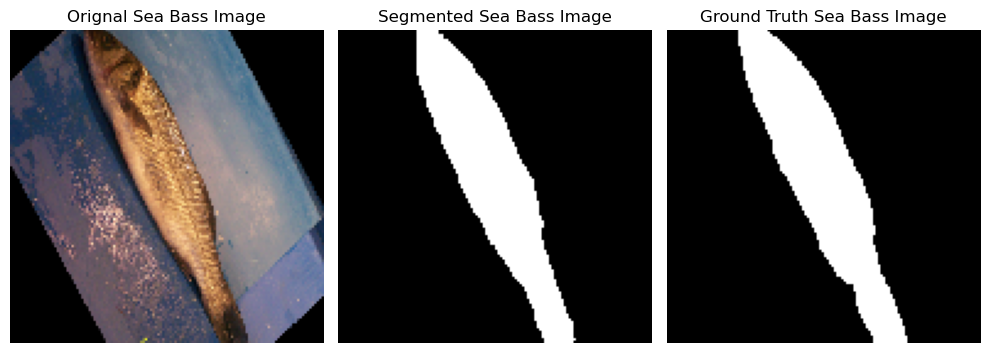

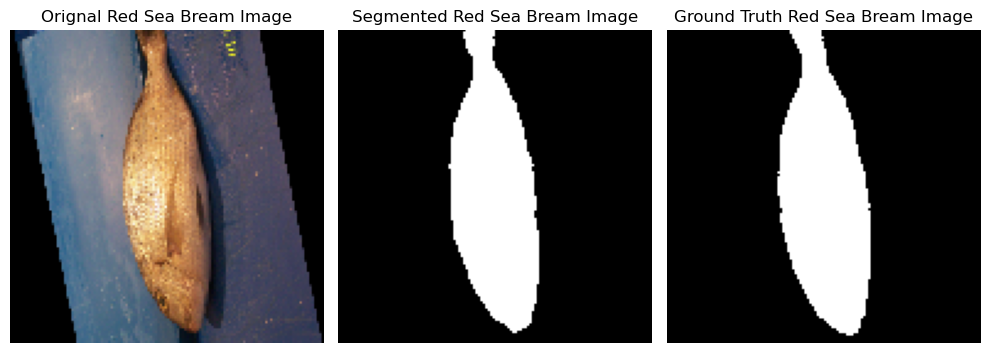

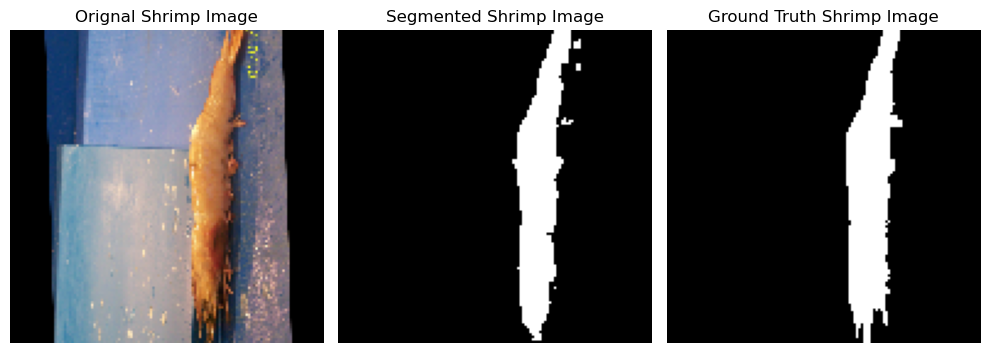

In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

image = cv2.imread("Fish_Dataset/Sea Bass/Sea Bass/00001.png")
height, width, channels = image.shape

# Load images
# SEA BASS
original = cv2.imread('Fish_Dataset/Sea Bass/Sea Bass/00001.png')
resized_orginal = cv2.resize(original, (128, 128), interpolation=cv2.INTER_NEAREST)

segmented = cv2.imread('Fish-Segmented/Sea Bass/Sea Bass000.png', cv2.IMREAD_GRAYSCALE)

gt = cv2.imread('GT/Sea Bass GT/00001.png', cv2.IMREAD_GRAYSCALE)
resized_gt = cv2.resize(gt, (128, 128), interpolation=cv2.INTER_NEAREST)

# RED SEA BREAM
original2 = cv2.imread('Fish_Dataset/Red Sea Bream/Red Sea Bream/00001.png')
resized_orginal2 = cv2.resize(original2, (128, 128), interpolation=cv2.INTER_NEAREST)

segmented2 = cv2.imread('Fish-Segmented/Red Sea Bream/Red Sea Bream000.png', cv2.IMREAD_GRAYSCALE)

gt2 = cv2.imread('GT/Red Sea Bream GT/00001.png', cv2.IMREAD_GRAYSCALE)
resized_gt2 = cv2.resize(gt2, (128, 128), interpolation=cv2.INTER_NEAREST)

# SHRMIP
original3 = cv2.imread('Fish_Dataset/Shrimp/Shrimp/00001.png')
resized_orginal3 = cv2.resize(original3, (128, 128), interpolation=cv2.INTER_NEAREST)

segmented3 = cv2.imread('Fish-Segmented/Shrimp/Shrimp000.png', cv2.IMREAD_GRAYSCALE)

gt3 = cv2.imread('GT/Shrimp GT/00001.png', cv2.IMREAD_GRAYSCALE)
resized_gt3 = cv2.resize(gt3, (128, 128), interpolation=cv2.INTER_NEAREST)



# Plot examples
fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # 1 row, 2 columns

axes[0].imshow(cv2.cvtColor(resized_orginal, cv2.COLOR_BGR2RGB))
axes[0].set_title("Orignal Sea Bass Image")
axes[0].axis('off')

axes[1].imshow(segmented, cmap='gray')
axes[1].set_title("Segmented Sea Bass Image")
axes[1].axis('off')

axes[2].imshow(resized_gt, cmap='gray')
axes[2].set_title("Ground Truth Sea Bass Image")
axes[2].axis('off')

plt.tight_layout()

plt.show()

# Plot examples
fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # 1 row, 2 columns

axes[0].imshow(cv2.cvtColor(resized_orginal2, cv2.COLOR_BGR2RGB))
axes[0].set_title("Orignal Red Sea Bream Image")
axes[0].axis('off')

axes[1].imshow(segmented2, cmap='gray')
axes[1].set_title("Segmented Red Sea Bream Image")
axes[1].axis('off')

axes[2].imshow(resized_gt2, cmap='gray')
axes[2].set_title("Ground Truth Red Sea Bream Image")
axes[2].axis('off')

plt.tight_layout()

plt.show()

# Plot examples
fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # 1 row, 2 columns

axes[0].imshow(cv2.cvtColor(resized_orginal3, cv2.COLOR_BGR2RGB))
axes[0].set_title("Orignal Shrimp Image")
axes[0].axis('off')

axes[1].imshow(segmented3, cmap='gray')
axes[1].set_title("Segmented Shrimp Image")
axes[1].axis('off')

axes[2].imshow(resized_gt3, cmap='gray')
axes[2].set_title("Ground Truth Shrimp Image")
axes[2].axis('off')

plt.tight_layout()

plt.show()

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

path = 'Fish_Dataset'
fish_dirs = [dir for dir in os.listdir(path) if os.path.isdir(os.path.join(path, dir))]
print(fish_dirs)

def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))

def calculateIoU(gtMask, predMask):
    # Calculate the true positives,
    # false positives, and false negatives
    tp = 0
    fp = 0
    fn = 0

    for i in range(len(gtMask)):
        for j in range(len(gtMask[0])):
            if gtMask[i][j] == 1 and predMask[i][j] == 1:
                tp += 1
            elif gtMask[i][j] == 0 and predMask[i][j] == 1:
                fp += 1
            elif gtMask[i][j] == 1 and predMask[i][j] == 0:
                fn += 1

    # Calculate IoU
    iou = tp / (tp + fp + fn)

    return iou

# Load training data and labels
dataset_dir = "Fish-Segmented"
segmented = []
gt = []
temp = []
name = []

classes = [i for i in os.listdir(path=dataset_dir) if "." not in i]
count = 0
for dir_name, _, filenames in os.walk("Fish-Segmented"):
    print(f"segmented{dir_name}")
    for filename in filenames:
        if os.path.splitext(filename)[-1] == ".png":
            temp.append(os.path.join(dir_name, filename))
            count += 1
            if count == 1000: 
                temp.sort()
                #print(temp)
                name.append(temp)
                temp = []
                count = 0

for fish in name:
    for i in range(1000):
        segmented_image = cv2.imread(fish[i], cv2.IMREAD_GRAYSCALE)
        _, pred_binary = cv2.threshold(segmented_image, 127, 1, cv2.THRESH_BINARY)
        segmented.append(pred_binary)


temp = []
name = []
processed = []
fish_type = ['Sea Bass','Red Mullet','Gilt-Head Bream','Red Sea Bream','Shrimp','Black Sea Sprat','Striped Red Mullet','Hourse Mackerel','Trout']
for fish in fish_type:  # Prioritize folders in the fish_type order
    for dir_name, _, filenames in os.walk("GT"):
        if fish in dir_name and fish not in processed:
            print(f"Processing folder: {dir_name}")
            processed.append(fish)
            for filename in filenames:
                if os.path.splitext(filename)[-1] == ".png":  # Filter PNG files
                    temp.append(os.path.join(dir_name, filename))
                    count += 1
                    if count == 1000:
                        temp.sort()
                        name.append(temp) 
                        temp = []
                        count = 0

for fish in name:
    for i in range(1000):
        gt_image = cv2.imread(fish[i], cv2.IMREAD_GRAYSCALE)
        _, true_binary = cv2.threshold(gt_image, 127, 1, cv2.THRESH_BINARY)
        resized_true = cv2.resize(true_binary, (128, 128), interpolation=cv2.INTER_NEAREST)
        gt.append(resized_true)
           
            
print(len(segmented)) 
print(len(gt))


# Calculate average dice
count = 0
for fish in fish_dirs:
    dice_sum = 0
    IoU_sum = 0
    for i in range(1000):
        dice = dice_coefficient(gt[count + i], segmented[count + i])
        dice_sum += dice
        IoU = calculateIoU(gt[count + i], segmented[count + i])
        IoU_sum += IoU
        
    print(f"{fish} Dice Coefficent: {dice_sum / 1000}")
    print(f"{fish} Iou: {IoU_sum / 1000}")
    count += 1000


['Sea Bass', 'Red Mullet', 'Gilt-Head Bream', 'Red Sea Bream', 'Shrimp', 'Black Sea Sprat', 'Striped Red Mullet', 'Hourse Mackerel', 'Trout']
segmentedFish-Segmented
segmentedFish-Segmented/Sea Bass
segmentedFish-Segmented/Red Mullet
segmentedFish-Segmented/Gilt-Head Bream
segmentedFish-Segmented/Red Sea Bream
segmentedFish-Segmented/Shrimp
segmentedFish-Segmented/Black Sea Sprat
segmentedFish-Segmented/Striped Red Mullet
segmentedFish-Segmented/Hourse Mackerel
segmentedFish-Segmented/Trout


[ WARN:0@392.941] global loadsave.cpp:241 findDecoder imread_('Fish-Segmented/Sea Bass/Sea Bass0.png'): can't open/read file: check file path/integrity


Processing folder: GT/Sea Bass GT
Processing folder: GT/Red Mullet GT
Processing folder: GT/Gilt-Head Bream GT
Processing folder: GT/Red Sea Bream GT
Processing folder: GT/Shrimp GT
Processing folder: GT/Black Sea Sprat GT
Processing folder: GT/Striped Red Mullet GT
Processing folder: GT/Hourse Mackerel GT
Processing folder: GT/Trout GT
9000
9000
Sea Bass Dice Coefficent: 0.9387601972716543
Sea Bass Iou: 0.89110584213018
Red Mullet Dice Coefficent: 0.9561604635959536
Red Mullet Iou: 0.9162153757498597
Gilt-Head Bream Dice Coefficent: 0.9694064474604007
Gilt-Head Bream Iou: 0.940727024508562
Red Sea Bream Dice Coefficent: 0.9679550354832037
Red Sea Bream Iou: 0.9385362250496762
Shrimp Dice Coefficent: 0.9251027735187505
Shrimp Iou: 0.8640376740163523
Black Sea Sprat Dice Coefficent: 0.9346990374638605
Black Sea Sprat Iou: 0.8806981938467072
Striped Red Mullet Dice Coefficent: 0.9426833645554964
Striped Red Mullet Iou: 0.8921443469068573
Hourse Mackerel Dice Coefficent: 0.941251237638710

# Fish Classification
## Option 2: Deep Learning-Based Classification

### Model Choice:

Use Convolutional Neural Networks (CNNs) to directly learn features and classify fish species from segmented images.
Alternatively, use pre-trained models (e.g., ResNet, VGG) for transfer learning.
Advantages: Deep learning models can automatically learn and optimize features, potentially leading to higher classification accuracy, especially on complex datasets.

### Evaluation Metrics

The F1-score and Confusion Matrix provide insight into model accuracy for each species, measuring how well the model distinguishes between different fish types.

Total image count: 9000
Preprocessing data...


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 42s 105ms/step - accuracy: 0.3822 - loss: 1.6429 - val_accuracy: 0.5285 - val_loss: 1.5590
Epoch 2/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - accuracy: 0.5714 - loss: 1.1460 - val_accuracy: 0.6018 - val_loss: 1.0584
Epoch 3/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 44s 111ms/step - accuracy: 0.6823 - loss: 0.8894 - val_accuracy: 0.6736 - val_loss: 0.8785
Epoch 4/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 52s 133ms/step - accuracy: 0.7326 - loss: 0.7271 - val_accuracy: 0.7047 - val_loss: 0.8225
Epoch 5/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 50s 126ms/step - accuracy: 0.8266 - loss: 0.5150 - val_accuracy: 0.7172 - val_loss: 0.7741
Epoch 6/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 48s 123ms/step - accuracy: 0.8488 - loss: 0.4235 - val_accuracy: 0.7594 - val_loss: 0.6843
Epoch 7/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 48s 123ms/step - accuracy: 0.9067 - loss: 0.2972 - val_accuracy: 0.7306 - val_loss: 0.7690
Epoch 8/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 47s 119ms/step - accuracy: 0.9313 - loss: 0

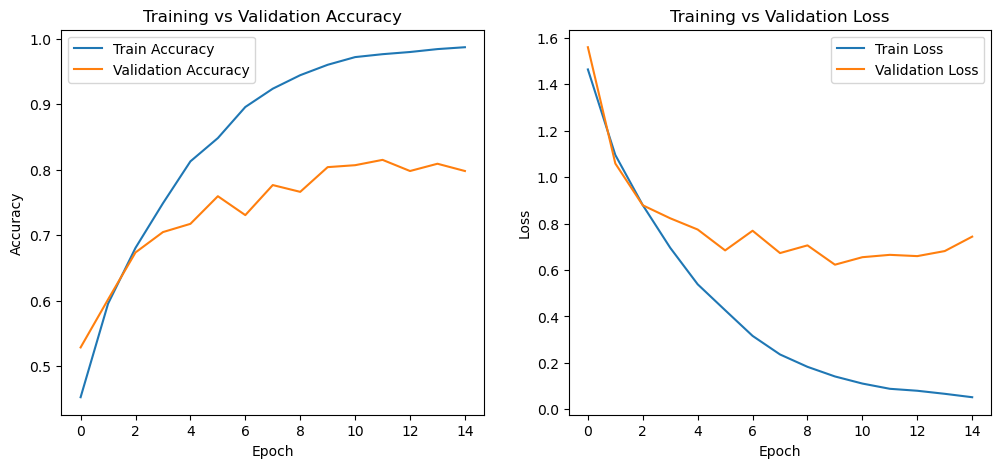

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.decomposition import PCA
import os
import random
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load training data and labels
dataset_dir = "Fish-Segmented"
image_paths = []
labels = []

classes = [i for i in os.listdir(path=dataset_dir) if "." not in i]

for dir_name, _, filenames in os.walk(dataset_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1] == ".png":
            labels.append(os.path.split(dir_name)[-1])
            image_paths.append(os.path.join(dir_name, filename))

df = pd.DataFrame({
    "path": image_paths,
    "label": labels
})

print(f"Total image count: {df.shape[0]}")
print("Preprocessing data...")

# Pre-processing of data
train_data, test_data = train_test_split(df, test_size=0.15, random_state=100, stratify=df['label'])
train_data, val_data = train_test_split(train_data, test_size=0.1765, random_state=100, stratify=train_data['label'])

def load_and_preprocess_images(df, img_width, img_height):
    images = []
    labels = []
    
    for index, row in df.iterrows():
        img = Image.open(row['path']).convert('RGB')
        img = img.resize((img_width, img_height))
        img = np.array(img) / 255.0
        images.append(img)
        labels.append(classes.index(row['label']))

    images = np.array(images)
    labels = np.array(labels)
    return images, labels


img_width, img_height = 128, 128

train_images, train_labels = load_and_preprocess_images(train_data, img_width, img_height)
test_images, test_labels = load_and_preprocess_images(test_data, img_width, img_height)
val_images, val_labels = load_and_preprocess_images(val_data, img_width, img_height)

train_labels = to_categorical(train_labels, num_classes=len(classes))
test_labels = to_categorical(test_labels, num_classes=len(classes))
val_labels = to_categorical(val_labels, num_classes=len(classes))

train_data, test_data = train_test_split(df, test_size=0.15, random_state=42, stratify=df['label'])
train_data, val_data = train_test_split(train_data, test_size=0.1765, random_state=42, stratify=train_data['label'])

X_test = []
for img_path in test_data['path']:
    img = Image.open(img_path)
    img = img.resize((img_width, img_height))  # Resize
    X_test.append(np.array(img))

X_test = np.array(X_test)

X_val = []
for img_path in val_data['path']:
    img = Image.open(img_path)
    img = img.resize((img_width, img_height))  # Resize
    X_val.append(np.array(img))

X_val = np.array(X_val)

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(len(classes), activation='softmax'))

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    epochs=20,
                    batch_size=16,
                    callbacks=[early_stopping])

# Print training and validation loss and accuracy
print("\nTraining Loss:", history.history['loss'][-1])
print("Validation Loss:", history.history['val_loss'][-1])

print("\nTraining Accuracy:", history.history['accuracy'][-1])
print("Validation Accuracy:", history.history['val_accuracy'][-1])

predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

y_true_labels = true_classes  # True labels
y_pred_labels = predicted_classes  # Predicted labels

# Print classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=classes))

# Compute confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
print(cm)

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()
